In [2]:
import pandas as pd
import torch
import numpy as np
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler
import random
import copy

In [37]:
# previously loaded data from 2013 - 2019 - now running on new data from 2005 to 2019
# data = pd.read_csv("../Current_Data/New_data_updated_names.csv", usecols=['Country','Date','Cases','Deaths','Summary'], 
#                   parse_dates=["Date"])
data = pd.read_csv("../Current_Data/data2005to2019.csv", usecols=['Country','Date','Cases','Deaths','Summary'],  
                  parse_dates=["Date"])
data.head()

,Country,Date,Cases,Deaths,Summary
0,Benin,2005-01-03,13,8.0,Note that year 2004 had 53 weeks. Hence the fi...
1,Burkina Faso,2005-01-03,106,23.0,Note that year 2004 had 53 weeks. Hence the fi...
2,Ivory Coast,2005-01-03,5,0.0,Note that year 2004 had 53 weeks. Hence the fi...
3,Mali,2005-01-03,18,0.0,Note that year 2004 had 53 weeks. Hence the fi...
4,Niger,2005-01-03,29,4.0,Note that year 2004 had 53 weeks. Hence the fi...


In [38]:
country_list = ['Benin', 'Burkina Faso', 'Burundi', 'Cameroun', 'Centrafrique', "Ivory Coast", 'Ethiopia', 'Ghana',
               'Guinea', 'Guinea Bissau', 'Gambia', 'Kenya', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Dem. Rep. Congo', 
                'Senegal' , 'South Sudan', 'Sudan', 'Sierra Lone', 'Tanzania', 'Chad', 'Togo', 'Uganda']
bordering_countries = {"Benin": ["Togo", "Nigeria", "Niger", "Burkina Faso"], 
                       "Burkina Faso": ["Mali", "Niger", "Benin" ,"Togo", "Ghana", "Ivory Coast"], 
                       "Burundi": ["Dem. Rep. Congo", "Tanzania"], 
                       "Cameroun": ["Centrafrique", "Nigeria", "Guinea", "Chad"], 
                       "Centrafrique": ["Cameroun", "Sudan", "South Sudan","Dem. Rep. Congo", "Chad"], 
                       "Ivory Coast": ["Ghana", "Mali", "Burkina Faso"], 
                       "Ethiopia": ["Sudan", "South Sudan", "Kenya"], 
                       "Ghana":["Guinea", "Ivory Coast", "Burkina Faso", "Togo"], 
                       "Guinea":["Ivory Coast", "Guinea Bissau", "Mali", "Senegal", "Sierra Lone"], 
                       "Guinea Bissau": ["Senegal", "Guinea"], 
                       "Gambia":["Senegal"], 
                       "Kenya": ["Ethiopia", "South Sudan", "Uganda"],
                       "Mali": ["Niger", "Burkina Faso", "Ivory Coast", "Guinea", "Mauritania", "Senegal"], 
                       "Mauritania":["Mali", "Senegal"], 
                       "Niger": ["Benin", "Nigeria", "Burkina Faso", "Mali", "Chad"], 
                       "Nigeria": ["Benin", "Cameroun", "Niger", "Chad"], 
                       "Dem. Rep. Congo": ["Burundi", "Centrafrique", "South Sudan", "Tanzania", "Uganda"], 
                       "Senegal":["Gambia", "Guinea", "Guinea Bissau", "Mali","Mauritania"], 
                       "South Sudan":["Sudan", "Ethiopia", "Kenya", "Dem. Rep. Congo", "Uganda","Centrafrique"], 
                       "Sudan":["Ethiopia", "South Sudan", "Centrafrique", "Chad"], 
                       "Sierra Lone": ["Guinea"], 
                       "Tanzania":["Kenya", "Uganda", "Burundi", "Dem. Rep. Congo"], 
                       "Chad":["Sudan", "Centrafrique", "Cameroun", "Niger", "Nigeria"], 
                       "Togo":["Ghana", "Burkina Faso","Benin", "Guinea"],
                       "Uganda":["Kenya", "South Sudan", "Dem. Rep. Congo", "Tanzania"]}
#this lambda function returns the index of the country from the corresponding country_list array
get_indices = lambda x: country_list.index(str(x).rstrip())
country_list.index("Guinea")

8

In [39]:
#creates a list of bordering countries for each datapoint with the countries represented as indices of country_list array
data_bordering_countries = pd.DataFrame(data["Country"].apply(lambda x: 
                                                              list(
                                                                  map(get_indices, 
                                                                      bordering_countries[str(x).rstrip()]))
                                                                   ))
data.insert(5, "Bordering Countries", data_bordering_countries)
#replace country names in country column with corresponding indices from country_list array
data["Country"] = data["Country"].apply(lambda x: country_list.index(str(x).rstrip()))
data.loc[0:20]

,Country,Date,Cases,Deaths,Summary,Bordering Countries
0,0,2005-01-03,13,8.0,Note that year 2004 had 53 weeks. Hence the fi...,"[23, 15, 14, 1]"
1,1,2005-01-03,106,23.0,Note that year 2004 had 53 weeks. Hence the fi...,"[12, 14, 0, 23, 7, 5]"
2,5,2005-01-03,5,0.0,Note that year 2004 had 53 weeks. Hence the fi...,"[7, 12, 1]"
3,12,2005-01-03,18,0.0,Note that year 2004 had 53 weeks. Hence the fi...,"[14, 1, 5, 8, 13, 17]"
4,14,2005-01-03,29,4.0,Note that year 2004 had 53 weeks. Hence the fi...,"[0, 15, 1, 12, 22]"
5,16,2005-01-03,61,12.0,Note that year 2004 had 53 weeks. Hence the fi...,"[2, 4, 18, 21, 24]"
6,22,2005-01-03,4,0.0,Note that year 2004 had 53 weeks. Hence the fi...,"[19, 4, 3, 14, 15]"
7,23,2005-01-03,7,1.0,Note that year 2004 had 53 weeks. Hence the fi...,"[7, 1, 0, 8]"
8,0,2005-01-10,7,1.0,"At week 2, 2005, the district of Saponé in Bur...","[23, 15, 14, 1]"
9,1,2005-01-10,156,37.0,"At week 2, 2005, the district of Saponé in Bur...","[12, 14, 0, 23, 7, 5]"


In [40]:
def find_next_batch(count):
    initialCount = count
    found = False
    while not found:
        count += 1
        if count == len(data) - 1 or data["Date"].loc[count + 1] != data["Date"].loc[count]:
            found = True
            break
    return data.iloc[initialCount:count+1]

In [41]:
find_next_batch(0)

,Country,Date,Cases,Deaths,Summary,Bordering Countries
0,0,2005-01-03,13,8.0,Note that year 2004 had 53 weeks. Hence the fi...,"[23, 15, 14, 1]"
1,1,2005-01-03,106,23.0,Note that year 2004 had 53 weeks. Hence the fi...,"[12, 14, 0, 23, 7, 5]"
2,5,2005-01-03,5,0.0,Note that year 2004 had 53 weeks. Hence the fi...,"[7, 12, 1]"
3,12,2005-01-03,18,0.0,Note that year 2004 had 53 weeks. Hence the fi...,"[14, 1, 5, 8, 13, 17]"
4,14,2005-01-03,29,4.0,Note that year 2004 had 53 weeks. Hence the fi...,"[0, 15, 1, 12, 22]"
5,16,2005-01-03,61,12.0,Note that year 2004 had 53 weeks. Hence the fi...,"[2, 4, 18, 21, 24]"
6,22,2005-01-03,4,0.0,Note that year 2004 had 53 weeks. Hence the fi...,"[19, 4, 3, 14, 15]"
7,23,2005-01-03,7,1.0,Note that year 2004 had 53 weeks. Hence the fi...,"[7, 1, 0, 8]"


In [42]:
find_next_batch(57)

,Country,Date,Cases,Deaths,Summary,Bordering Countries
57,0,2005-03-07,4,2.0,Batié district in Burkina remained in epidemic...,"[23, 15, 14, 1]"
58,1,2005-03-07,164,35.0,Batié district in Burkina remained in epidemic...,"[12, 14, 0, 23, 7, 5]"
59,7,2005-03-07,8,3.0,Batié district in Burkina remained in epidemic...,"[8, 5, 1, 23]"
60,12,2005-03-07,21,0.0,Batié district in Burkina remained in epidemic...,"[14, 1, 5, 8, 13, 17]"
61,16,2005-03-07,108,17.0,Batié district in Burkina remained in epidemic...,"[2, 4, 18, 21, 24]"


In [43]:
data.loc[0:54]["Country"].unique()

array([ 0,  1,  5, 12, 14, 16, 22, 23,  7])

### Convert Weekly Data into Montly to Analyze Distributions

In [44]:
def update_batch(temp_batch, curr_batch):
    for index, row in curr_batch.iterrows():
            #check if the country is in the temp monthly batch, if not add it, otherwise update Cases, Deaths, and Summary
            if row["Country"] not in temp_batch["Country"].unique():
                if len(temp_batch) != 0:
                    row["Date"] = temp_batch["Date"].iloc[0]
                temp_batch = temp_batch.append(row)
            else:
                temp_batch.loc[temp_batch.Country == row["Country"], "Cases"] += row["Cases"]
                temp_batch.loc[temp_batch.Country == row["Country"], "Deaths"] += row["Deaths"]
                temp_batch.loc[temp_batch.Country == row["Country"], "Summary"] += "." + row["Summary"]
    return temp_batch
    
#Convert the weekly data into montly data (by summing over the Cases, Deaths, and concatenating the summaries)
count = 0
new_monthly_data = pd.DataFrame(columns=["Country", "Date", "Cases", "Deaths", "Summary", "Bordering Countries"])
#create a temporary dataframe for current month which will be concatenated to the final dataframe
temp_batch = new_monthly_data.copy()
curr_month = 1
#The upper-bound is determined by the number which when passed to the find_next_batch function will return the final batch
while count <= 2806:
    curr_batch = find_next_batch(count)
    count += len(curr_batch)
    #if the new batch is of a different month, add it to the new_monthly_data dataframe and empty the temp_batch for the new month
    if curr_batch["Date"].iloc[0].month != curr_month:
        curr_month = curr_batch["Date"].iloc[0].month
        new_monthly_data = pd.concat([new_monthly_data, temp_batch], ignore_index = True)
        temp_batch = pd.DataFrame(columns=["Country", "Date", "Cases", "Deaths", "Summary", "Bordering Countries"])
    temp_batch = update_batch(temp_batch, curr_batch)

new_monthly_data.to_csv("../Current_Data/Month_data.csv")

    

### Plotting Histograms With No. Of Cases for Each Country

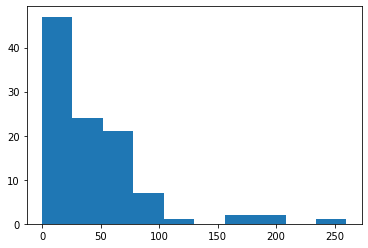

Benin
Statistics=69.128, p=0.000
Sample does not look Gaussian (reject H0)


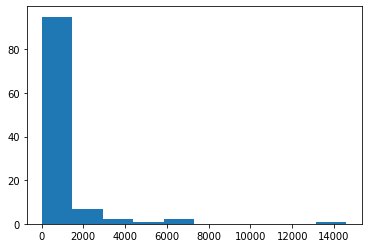

Burkina Faso
Statistics=155.596, p=0.000
Sample does not look Gaussian (reject H0)


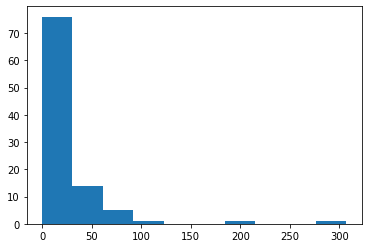

Ivory Coast
Statistics=134.532, p=0.000
Sample does not look Gaussian (reject H0)


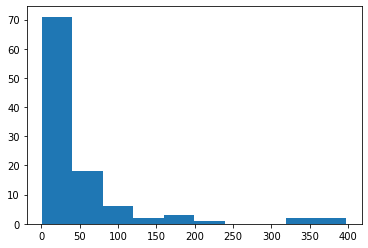

Mali
Statistics=92.515, p=0.000
Sample does not look Gaussian (reject H0)


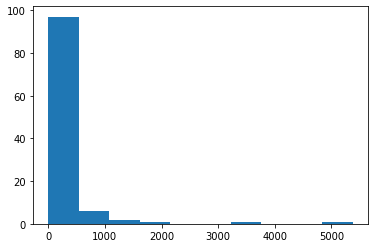

Niger
Statistics=163.315, p=0.000
Sample does not look Gaussian (reject H0)


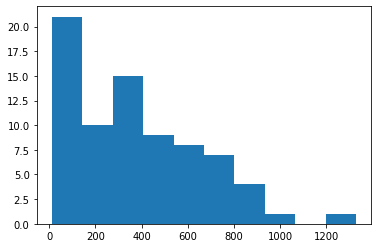

Dem. Rep. Congo
Statistics=9.606, p=0.008
Sample does not look Gaussian (reject H0)


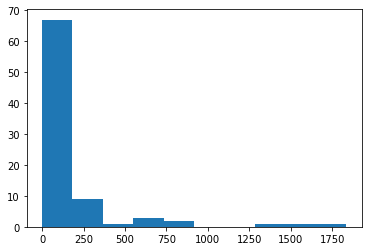

Chad
Statistics=85.923, p=0.000
Sample does not look Gaussian (reject H0)


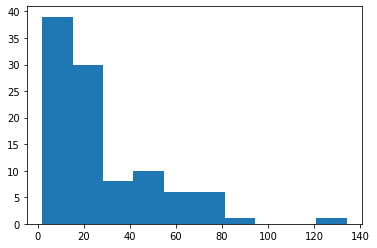

Togo
Statistics=48.428, p=0.000
Sample does not look Gaussian (reject H0)


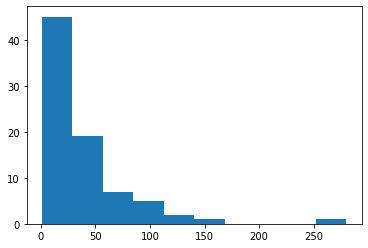

Ghana
Statistics=75.473, p=0.000
Sample does not look Gaussian (reject H0)


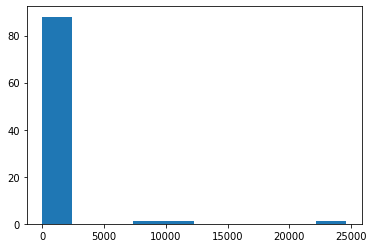

Nigeria
Statistics=164.628, p=0.000
Sample does not look Gaussian (reject H0)


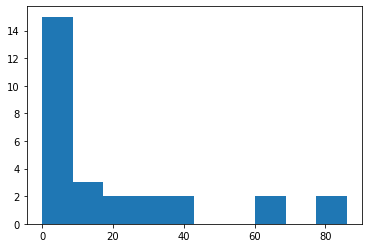

Ethiopia
Statistics=10.784, p=0.005
Sample does not look Gaussian (reject H0)


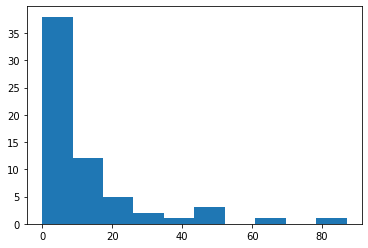

Centrafrique
Statistics=45.978, p=0.000
Sample does not look Gaussian (reject H0)


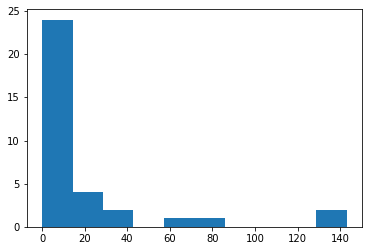

Guinea
Statistics=37.080, p=0.000
Sample does not look Gaussian (reject H0)


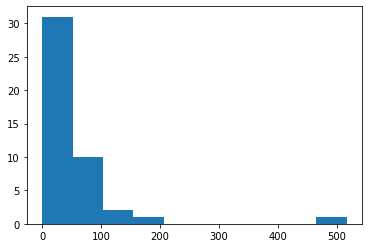

Cameroun
Statistics=77.286, p=0.000
Sample does not look Gaussian (reject H0)


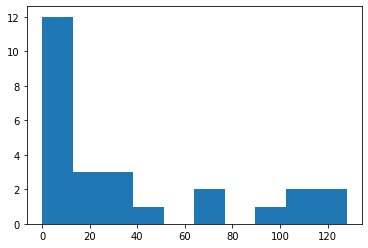

Sudan
Statistics=5.371, p=0.068
Sample looks Gaussian (fail to reject H0)


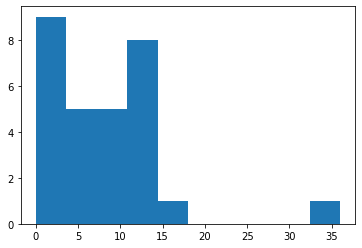

Gambia
Statistics=24.920, p=0.000
Sample does not look Gaussian (reject H0)


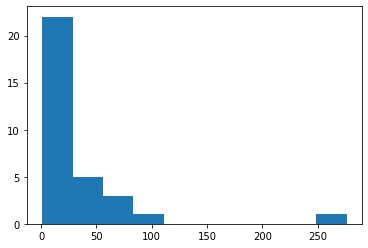

Senegal
Statistics=56.589, p=0.000
Sample does not look Gaussian (reject H0)


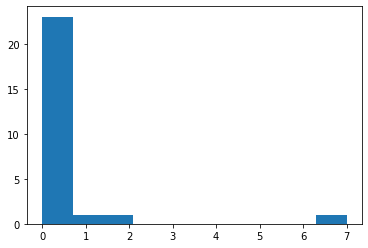

Mauritania
Statistics=57.067, p=0.000
Sample does not look Gaussian (reject H0)


In [49]:
"""This function will go through any time-series data in a pandas dataframe e.g. weekly, monthly cases etc. and 
return two dic with 
data_dict: countries as keys and a list of datapoints (weekly, monthly, yearly etc.) as the values
threshold_dict: countries as keys and list representing the 30th and 70th percentiles as values

"""
def time_series_to_dict(df, thresholds_needed=False):
    data_dict = {}
    threshold_dict = {}
    for i in range(2005, 2020):
        curr_yr = df.loc[df.Date.dt.year == i]
        countries_list=list(curr_yr["Country"].unique())
        for country in countries_list:
            country_curr_yr = curr_yr[curr_yr.Country == country]
            first_percentile = country_curr_yr["Cases"].quantile(0.3)
            second_percentile =  country_curr_yr["Cases"].quantile(0.7)
            threshold_dict[country] = [first_percentile, second_percentile]
            if country not in data_dict:
                data_dict[country] = country_curr_yr["Cases"].tolist()
            else:
                data_dict[country]+= country_curr_yr["Cases"].tolist()
    if thresholds_needed:
        return data_dict, threshold_dict
    return data_dict

monthly_data_dict = time_series_to_dict(new_monthly_data)


#Apply a normal test to see if the data for each country reflects a Gaussian distribution.
# A 5% significiance level is used for each country (and the null hypothesis is rejected if p-value <0.05)
for key, values in monthly_data_dict.items():
    if len(values) > 20:

        plt.hist(values)
        plt.show()
        stat, p = normaltest(values)
        print(country_list[key])
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')
        
        

### Determining State Thresholds for Each Country 
To determine the threshold for each country (i.e. no. of cases for each country that will determine whether the severity is low, medium, or high), we will start by computing independent thresholds for each country. Since each country has different populations, factors affecting the spread of the pandemic (e.g. no. of people vaccinated etc.), the same number of cases in different locations has different implications (e.g. 10 cases for a population of 100 is much more dangerous than 10 for 1,000,000. The thresholds for low, medium, and high will be the values that account fo 30%, 40%, and 30% respectively. In other words, each country will have two thresholds at the 30th and 70th and percentiles (calculated from the time_series_to_dict function above).

0 = low  

1 = medium 

2 = high

In [50]:
#what to do data with thresholds of 0,0? For now drop
_, thresholds_weekly_data = time_series_to_dict(data, True)
for country, thresholds in thresholds_weekly_data.items():
    #*NOTE updated thresholds which are now ignored to include 0 and 1 or 0 and 2
    if (thresholds[0] == 0 and thresholds[1] == 0) or (thresholds[0] == 0 and thresholds[1] <= 2):
        indexNames = data[data['Country'] == country ].index
        data = data.drop(indexNames, axis=0)
        print(country)

weekly_data_dict, thresholds_weekly_data = time_series_to_dict(data, True)

data["State"] = 0
def find_state(country_threshold_list, no_cases):
    if no_cases >= float(country_threshold_list[1]):
        return 2
    elif no_cases >= float(country_threshold_list[0]):
        return 1
    else:
        return 0


#find the state for each country by comparing the number of cases to the corresponding thresholds 
data["State"] = data.apply(lambda x: find_state(thresholds_weekly_data[x["Country"]], x["Cases"]) ,axis=1)
data.head()
scaler = MinMaxScaler()
scaled_data = data.copy()
scaled_data[["Cases", "Deaths"]] = scaler.fit_transform(scaled_data[["Cases", "Deaths"]])
scaled_data.head()
weekly_data_dict_scaled, thresholds_weekly_data_scaled = time_series_to_dict(scaled_data, True)
print(weekly_data_dict)

{0: [13, 7, 13, 14, 13, 10, 5, 4, 3, 2, 2, 0, 4, 12, 13, 14, 5, 3, 10, 9, 14, 10, 1, 2, 4, 7, 26, 4, 12, 12, 23, 22, 27, 10, 12, 17, 44, 3, 4, 19, 7, 16, 9, 42, 57, 14, 14, 18, 17, 16, 18, 23, 4, 19, 5, 2, 18, 8, 6, 6, 3, 5, 4, 4, 4, 4, 9, 21, 19, 5, 19, 16, 33, 11, 11, 11, 66, 11, 15, 5, 13, 14, 4, 4, 3, 1, 3, 1, 3, 2, 4, 1, 0, 21, 20, 20, 20, 39, 12, 11, 5, 4, 22, 13, 13, 13, 15, 8, 11, 8, 12, 16, 16, 7, 4, 5, 4, 5, 5, 6, 2, 3, 7, 14, 16, 8, 8, 14, 8, 10, 11, 9, 150, 9, 7, 10, 14, 12, 166, 6, 5, 11, 1, 5, 6, 7, 4, 1, 2, 2, 1, 6, 0, 16, 14, 9, 19, 11, 8, 9, 21, 33, 31, 30, 65, 73, 45, 64, 61, 90, 66, 51, 26, 15, 22, 20, 12, 7, 7, 10, 8, 8, 99, 59, 55, 43, 21, 14, 21, 26, 25, 26, 26, 38, 38, 35, 24, 15, 14, 18, 11, 12, 11, 8, 17, 16, 21, 12, 8, 20, 47, 66, 51, 67, 46, 48, 11, 14, 12, 18, 15, 25, 20, 17, 24, 15, 20, 16, 17, 11, 9, 16, 15, 12, 14, 17, 20, 18, 16, 14, 17, 14, 65, 63, 37, 57, 44, 28, 9, 5, 7, 5, 8, 5, 6, 5, 11, 10, 9, 6, 7, 10, 11, 10, 8, 0, 5, 6, 9, 7, 12, 12, 6, 67, 46, 

In [51]:
test = []
burkina_faso_data = []
def return_features_labels(window_size, weekly_dict, thresholds, state=True):
    #input data is an array of tuples (features, label) where features is the sequence data of no. of cases and label 
#is the state
    input_data = []
    #array of tuples of (features, label) where label is also a tuple of (country, no. of case at t+1, state at t+1)
    continuous_data = []
    for country, cases in weekly_dict.items():
        for i in range(len(cases)-window_size-1):
            features = cases[i:i+window_size]
            label = find_state(thresholds[country], cases[i+1+window_size])
            input_data.append((features, label))
            continuous_data.append((features, (country, cases[i+1+window_size], label)))
            if country == 1 and window_size==4:
                burkina_faso_data.append((features, (country, cases[i+1+window_size], label)))
    if state == False:
        return continuous_data
    return input_data
#uncommented to so burkina_faso data won't work
# a = return_features_labels(4, weekly_data_dict, thresholds_weekly_data)
input_data_4 = return_features_labels(4, weekly_data_dict, thresholds_weekly_data)
input_data_5 = return_features_labels(5, weekly_data_dict, thresholds_weekly_data, state=False)
input_data_6 = return_features_labels(6, weekly_data_dict, thresholds_weekly_data, state=False)
input_data_7 = return_features_labels(7, weekly_data_dict, thresholds_weekly_data, state=False)
continuous_data = return_features_labels(4, weekly_data_dict, thresholds_weekly_data, state = False)
continuous_data_10 = return_features_labels(10, weekly_data_dict, thresholds_weekly_data, state=False)
np.save("transformer/continuous_data_10.csv", np.asarray(continuous_data_10))
print(continuous_data_10)
# input_data_4_scaled = return_features_labels(4, weekly_data_dict_scaled, thresholds_weekly_data_scaled)

[([13, 7, 13, 14, 13, 10, 5, 4, 3, 2], (0, 0, 0)), ([7, 13, 14, 13, 10, 5, 4, 3, 2, 2], (0, 4, 0)), ([13, 14, 13, 10, 5, 4, 3, 2, 2, 0], (0, 12, 1)), ([14, 13, 10, 5, 4, 3, 2, 2, 0, 4], (0, 13, 1)), ([13, 10, 5, 4, 3, 2, 2, 0, 4, 12], (0, 14, 1)), ([10, 5, 4, 3, 2, 2, 0, 4, 12, 13], (0, 5, 0)), ([5, 4, 3, 2, 2, 0, 4, 12, 13, 14], (0, 3, 0)), ([4, 3, 2, 2, 0, 4, 12, 13, 14, 5], (0, 10, 1)), ([3, 2, 2, 0, 4, 12, 13, 14, 5, 3], (0, 9, 1)), ([2, 2, 0, 4, 12, 13, 14, 5, 3, 10], (0, 14, 1)), ([2, 0, 4, 12, 13, 14, 5, 3, 10, 9], (0, 10, 1)), ([0, 4, 12, 13, 14, 5, 3, 10, 9, 14], (0, 1, 0)), ([4, 12, 13, 14, 5, 3, 10, 9, 14, 10], (0, 2, 0)), ([12, 13, 14, 5, 3, 10, 9, 14, 10, 1], (0, 4, 0)), ([13, 14, 5, 3, 10, 9, 14, 10, 1, 2], (0, 7, 1)), ([14, 5, 3, 10, 9, 14, 10, 1, 2, 4], (0, 26, 2)), ([5, 3, 10, 9, 14, 10, 1, 2, 4, 7], (0, 4, 0)), ([3, 10, 9, 14, 10, 1, 2, 4, 7, 26], (0, 12, 1)), ([10, 9, 14, 10, 1, 2, 4, 7, 26, 4], (0, 12, 1)), ([9, 14, 10, 1, 2, 4, 7, 26, 4, 12], (0, 23, 2)), ([14, 10,

In [52]:
for country, values in weekly_data_dict.items():
    print(country_list[country], " : ", len(values))

Benin  :  399
Burkina Faso  :  425
Ivory Coast  :  335
Mali  :  403
Niger  :  380
Dem. Rep. Congo  :  195
Chad  :  303
Togo  :  366
Ghana  :  264
Nigeria  :  345
Ethiopia  :  102
Centrafrique  :  212
Guinea  :  190
Cameroun  :  168
Senegal  :  221
Kenya  :  34
Uganda  :  19
Burundi  :  22


Above is a list of all of the countries being included in the final input_data that is passed into the LSTM. The number of recorded datapoints for different countries seems to be extremely disproportionate. This means that once source of error when testing is that the data comes from a different distribution to the training data (i.e. we train on data for example only on Burkina Faso and the test data contains data for Uganda).

One potential problem:

When I collect data, and put into a large array [1, 0, 2] I assume that each datapoint is the recorded number of cases for the week after the first one. In practice, this may not necessarily be the case for all the datapoints (could be months or even years apart) - how do I handle this?

Also difference in temporal time frame between inital weekly and later monthly data (sequence are representing different temporal timeframes)

Strategies for handling missing data
1. Only use data without gaps (as I have done)
2. Fill in the gaps (e.g. with the last observed value or the median)

In [25]:

print(burkina_faso_data)

[([88, 97, 100, 100], (1, 76, 1)), ([97, 100, 100, 99], (1, 127, 2)), ([100, 100, 99, 76], (1, 129, 2)), ([100, 99, 76, 127], (1, 141, 2)), ([99, 76, 127, 129], (1, 164, 2)), ([76, 127, 129, 141], (1, 186, 2)), ([127, 129, 141, 164], (1, 216, 2)), ([129, 141, 164, 186], (1, 197, 2)), ([141, 164, 186, 216], (1, 166, 2)), ([164, 186, 216, 197], (1, 163, 2)), ([186, 216, 197, 166], (1, 135, 2)), ([216, 197, 166, 163], (1, 104, 2)), ([197, 166, 163, 135], (1, 84, 1)), ([166, 163, 135, 104], (1, 66, 1)), ([163, 135, 104, 84], (1, 47, 1)), ([135, 104, 84, 66], (1, 45, 1)), ([104, 84, 66, 47], (1, 44, 1)), ([84, 66, 47, 45], (1, 27, 1)), ([66, 47, 45, 44], (1, 27, 1)), ([47, 45, 44, 27], (1, 34, 1)), ([45, 44, 27, 27], (1, 143, 2)), ([44, 27, 27, 34], (1, 155, 2)), ([27, 27, 34, 143], (1, 101, 2)), ([27, 34, 143, 155], (1, 140, 2)), ([34, 143, 155, 101], (1, 25, 1)), ([143, 155, 101, 140], (1, 118, 2)), ([155, 101, 140, 25], (1, 34, 1)), ([101, 140, 25, 118], (1, 50, 1)), ([140, 25, 118, 34],

In [26]:
print(thresholds_weekly_data)

{0: [6.299999999999999, 14.7], 1: [20.69999999999998, 93.5], 5: [3.0, 5.799999999999997], 7: [15.0, 38.4], 12: [9.299999999999999, 15.399999999999999], 15: [27.0, 60.0], 17: [9.399999999999999, 18.0], 22: [12.0, 36.0], 23: [11.0, 27.89999999999999], 3: [12.2, 18.4], 8: [6.699999999999999, 14.299999999999997], 14: [9.5, 29.5], 4: [4.0, 11.599999999999998], 16: [127.59999999999998, 168.2], 6: [29.799999999999997, 39.4], 11: [2.0, 5.0], 24: [31.0, 31.0], 2: [3.299999999999999, 11.0]}
